<a href="https://colab.research.google.com/github/vidhishah22/CMPE-297-EmergingTech/blob/master/LeNet%26VGG16_Final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Assignment 2: LeNet (modified) and VGG models in colab </h1>


---

Submission By: Vidhi Shah

References:<br>

*   https://medium.com/tensorflow/tf-keras-on-tpus-on-colab-674367932aa0
*   https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
*   https://mc.ai/here-we-will-create-a-simple-cats-and-dogs-classification-model-using-keras-the/
*   https://www.tensorflow.org/tutorials/images/classification
*   https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb


In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import keras, os
keras.__version__
import os, shutil
import numpy as np
#!pip install tensorflow==1.13.1
import tensorflow as tf
tf.__version__ 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import plot_model

<h3> Load Data</h3>

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 2s 0us/step


In [0]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [0]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

<h3>Understand the data</h3>

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [104]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [0]:
batch_size = 128
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

<h3>Configuring Keras on TPUs in Colab</h3>

In [106]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.90.210.18:8470


<h3>Data preparation</h3>

In [0]:
# Use a tf optimizer rather than a Keras one for now
learning_rate = 1e-4
opt = tf.train.AdamOptimizer(learning_rate)

In [78]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        shuffle=True,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [108]:
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        directory=validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


<h3>Visualize training images</h3>

In [0]:
sample_training_images, _ = next(train_generator)

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, subplt):
    fig, axes = plt.subplots(1, subplt, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

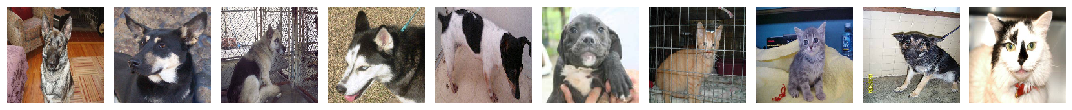

In [69]:
plotImages(sample_training_images[:10], 10)

<h3> LeNet</h3>

In [0]:
model_lenet = models.Sequential()
model_lenet.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(150,150,3)))
model_lenet.add(layers.AveragePooling2D())
model_lenet.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_lenet.add(layers.AveragePooling2D())
model_lenet.add(layers.Flatten())
model_lenet.add(layers.Dense(units=120, activation='relu'))
model_lenet.add(layers.Dense(units=84, activation='relu'))
model_lenet.add(layers.Dense(units=1, activation = 'sigmoid'))

In [110]:
model_lenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 148, 148, 6)       168       
_________________________________________________________________
average_pooling2d_6 (Average (None, 74, 74, 6)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 72, 72, 16)        880       
_________________________________________________________________
average_pooling2d_7 (Average (None, 36, 36, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               2488440   
_________________________________________________________________
dense_19 (Dense)             (None, 84)                10164     
__________

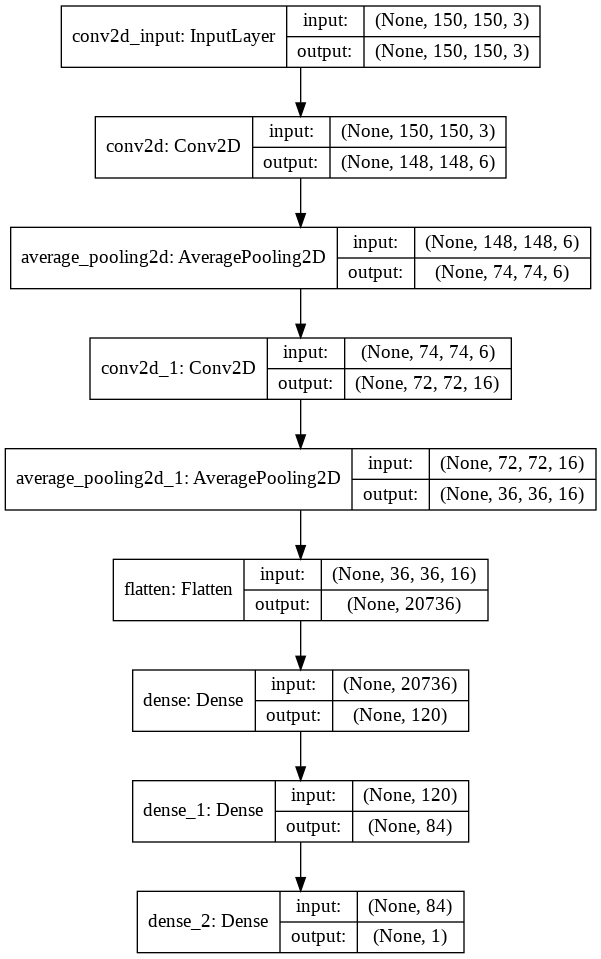

In [54]:
plot_model(model_lenet, show_shapes=True, to_file='lenet.png')

In [0]:
model_lenet.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [25]:
tpu_model_lenet = tf.contrib.tpu.keras_to_tpu_model(
    model_lenet,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

INFO:tensorflow:Querying Tensorflow master (grpc://10.90.210.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15688695841910164116)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14969294123631976447)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5898485614081231204)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15154605458810267110)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 9207542379609240)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/j

In [30]:
history_lenet = tpu_model_lenet.fit_generator(
      train_generator,
      steps_per_epoch=total_train,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=total_val)

Epoch 1/30
16/16 [==============================] - 14s 898ms/step - loss: 0.5138 - acc: 0.7775 - val_loss: 0.5941 - val_acc: 0.6860
Epoch 2/30
16/16 [==============================] - 14s 889ms/step - loss: 0.5106 - acc: 0.7525 - val_loss: 0.6218 - val_acc: 0.6510
Epoch 3/30
16/16 [==============================] - 14s 888ms/step - loss: 0.5077 - acc: 0.7605 - val_loss: 0.5859 - val_acc: 0.7000
Epoch 4/30
16/16 [==============================] - 14s 883ms/step - loss: 0.4871 - acc: 0.7825 - val_loss: 0.5953 - val_acc: 0.6760
Epoch 5/30
16/16 [==============================] - 14s 874ms/step - loss: 0.4654 - acc: 0.7995 - val_loss: 0.5877 - val_acc: 0.7000
Epoch 6/30
16/16 [==============================] - 14s 882ms/step - loss: 0.4577 - acc: 0.8065 - val_loss: 0.5868 - val_acc: 0.6900
Epoch 7/30
16/16 [==============================] - 14s 870ms/step - loss: 0.4429 - acc: 0.8190 - val_loss: 0.5870 - val_acc: 0.6890
Epoch 8/30
16/16 [==============================] - 14s 882ms/step - 

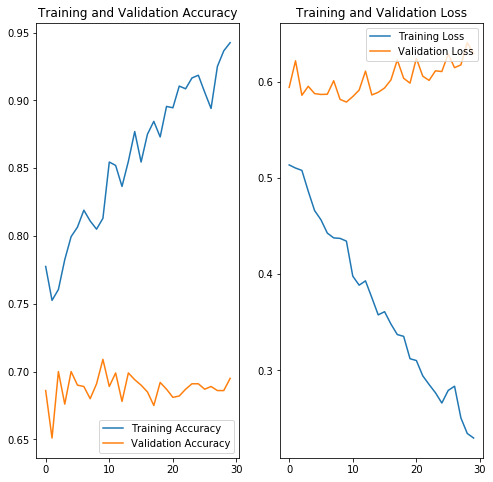

In [32]:

acc = history_lenet.history['acc']
val_acc = history_lenet.history['val_acc']

loss = history_lenet.history['loss']
val_loss = history_lenet.history['val_loss']
epochs = 30
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h3>Vgg16</h3>

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation='relu',input_shape=(150,150,3)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(layers.Conv2D(filters=128,kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(4096,activation="relu"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4096,activation="relu"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 37, 37, 256)       295168    
__________

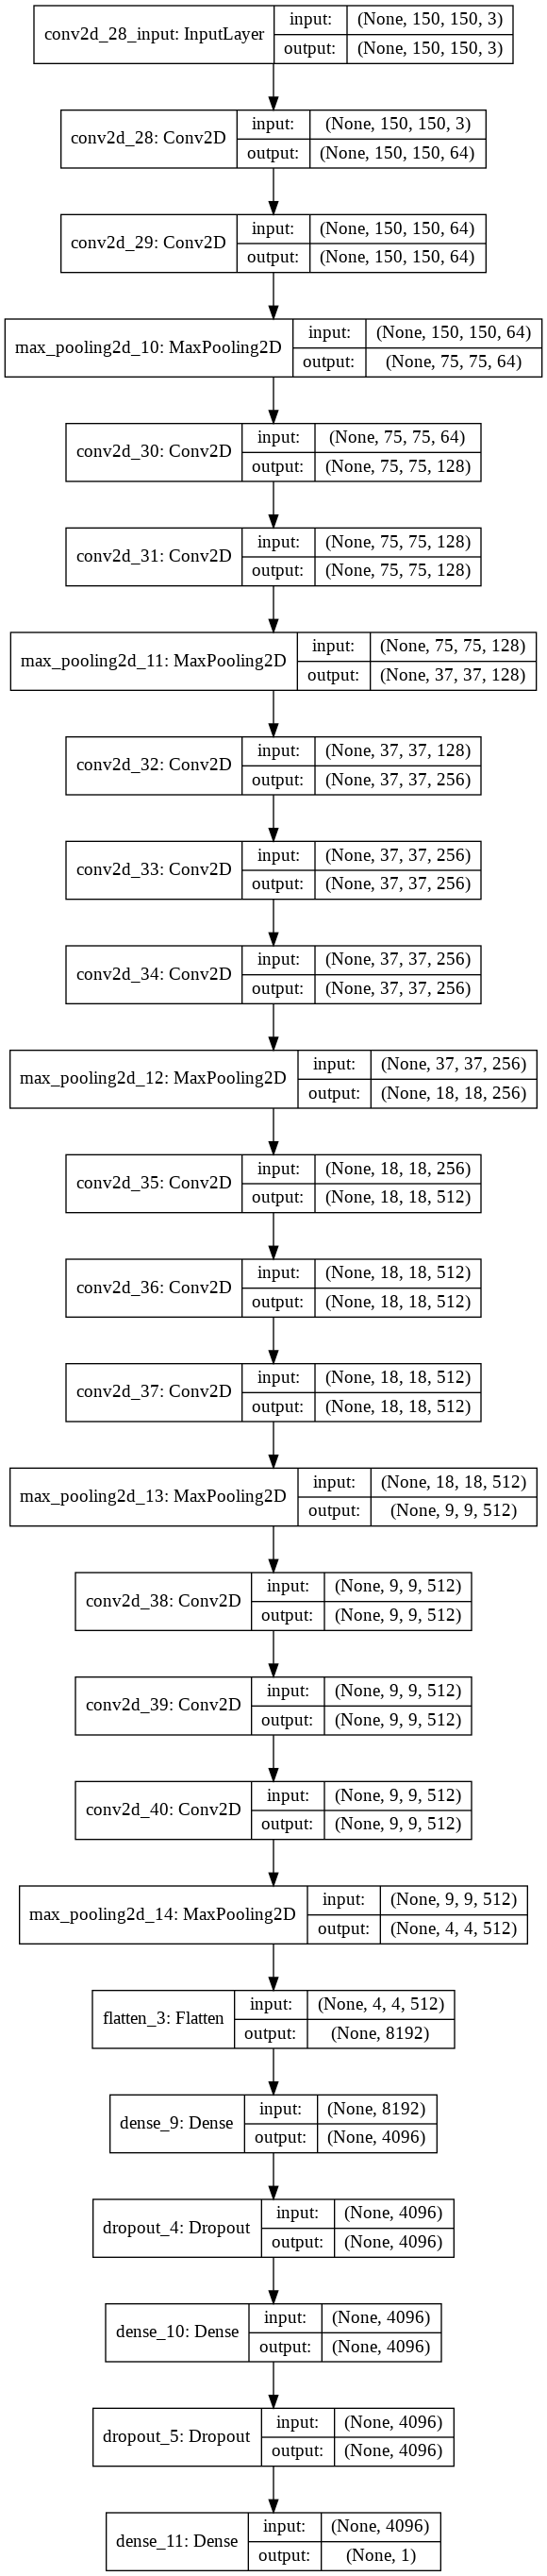

In [53]:
plot_model(model, show_shapes=True, to_file='vgg_16.png')

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
# from time import time
# from keras.callbacks import TensorBoard
# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [47]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

INFO:tensorflow:Querying Tensorflow master (grpc://10.90.210.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15688695841910164116)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14969294123631976447)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5898485614081231204)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15154605458810267110)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 9207542379609240)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/j

In [48]:
history_vgg = tpu_model.fit_generator(
      train_generator,
      steps_per_epoch=total_train,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=total_val)

Epoch 1/30
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_40'), TensorSpec(shape=(16, 150, 150, 3), dtype=tf.float32, name='conv2d_28_input_10'), TensorSpec(shape=(16, 1), dtype=tf.float32, name='dense_11_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_28_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 21.180328130722046 secs
INFO:tensorflow:Setting weights on TPU model.
15/16 [===========================>..] - ETA: 3s - loss: 0.6932 - acc: 0.4901INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(10,), dtype=tf.int32, name='core_id_40'), TensorSpec(shape=(10, 150, 150, 3), dtype=tf.float32, name='conv2d_28_input_10'), TensorSpec(shape=(10, 1), dtype=tf.float32, name='dense_11_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Rema

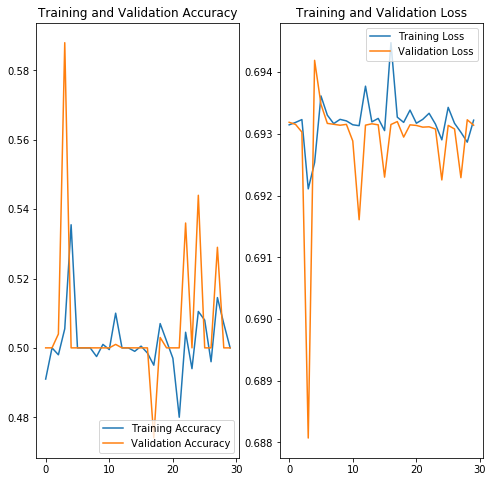

In [51]:

acc_vgg = history_vgg.history['acc']
val_acc_vgg = history_vgg.history['val_acc']

loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_vgg, label='Training Accuracy')
plt.plot(epochs_range, val_acc_vgg, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_vgg, label='Training Loss')
plt.plot(epochs_range, val_loss_vgg, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h3>Data augmentation to avoid Overfitting</h3>

In [65]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
        directory=train_dir,
        shuffle=True,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size)

Found 2000 images belonging to 2 classes.


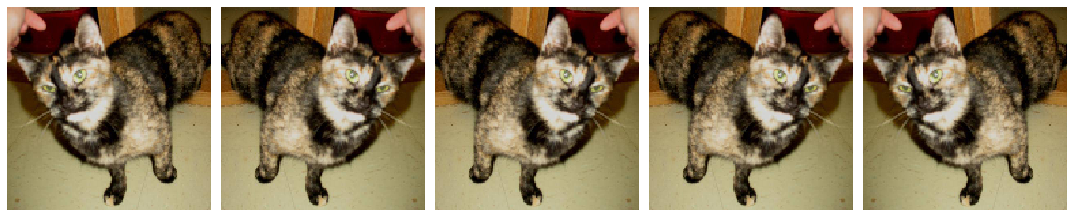

In [70]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images,5)

Found 2000 images belonging to 2 classes.


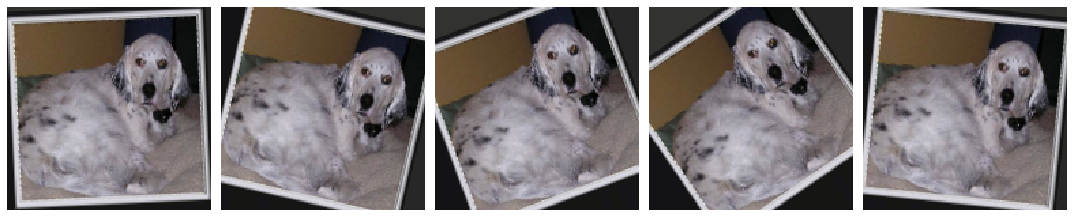

In [71]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images,5)

Found 2000 images belonging to 2 classes.


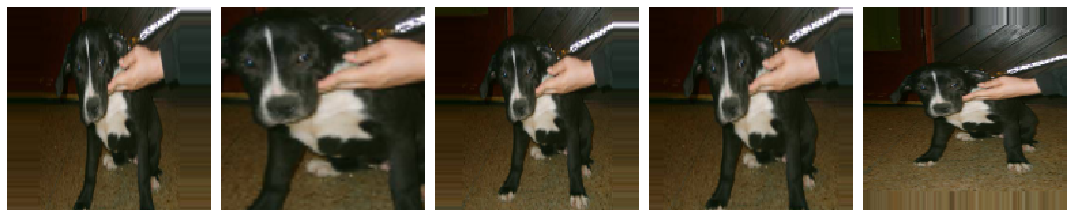

In [72]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images,5)

Found 2000 images belonging to 2 classes.


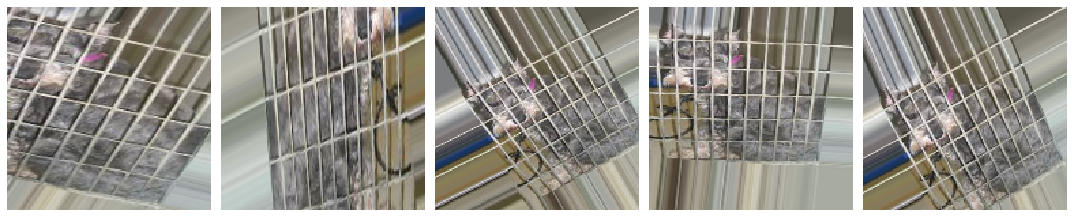

In [112]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images,5)

<h3> LeNet Modified (Training data with augmentation)</h3>

In [113]:
tpu_model_lenet_modified = tf.contrib.tpu.keras_to_tpu_model(
    model_lenet,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

INFO:tensorflow:Querying Tensorflow master (grpc://10.90.210.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15688695841910164116)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14969294123631976447)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5898485614081231204)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15154605458810267110)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 9207542379609240)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/j

In [114]:
history_lenet_modified = tpu_model_lenet_modified.fit_generator(
      train_data_gen,
      steps_per_epoch=total_train,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=total_val)

Epoch 1/30
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_100'), TensorSpec(shape=(16, 150, 150, 3), dtype=tf.float32, name='conv2d_45_input_10'), TensorSpec(shape=(16, 1), dtype=tf.float32, name='dense_20_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_45_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 20.84206485748291 secs
INFO:tensorflow:Setting weights on TPU model.
13/16 [=======================>......] - ETA: 9s - loss: 0.6977 - acc: 0.4898 INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(10,), dtype=tf.int32, name='core_id_100'), TensorSpec(shape=(10, 150, 150, 3), dtype=tf.float32, name='conv2d_45_input_10'), TensorSpec(shape=(10, 1), dtype=tf.float32, name='dense_20_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Re

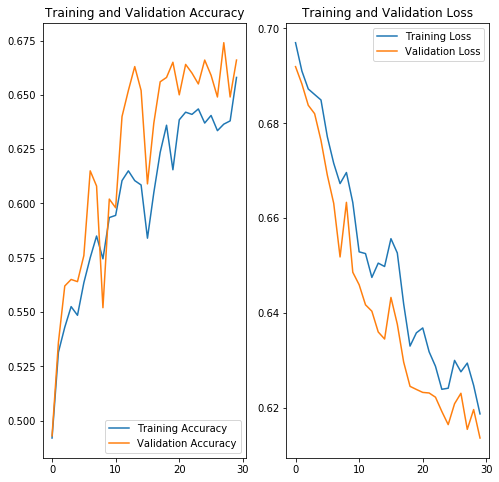

In [115]:

acc_lenetm = history_lenet_modified.history['acc']
val_acc_lenetm = history_lenet_modified.history['val_acc']

loss_lenetm = history_lenet_modified.history['loss']
val_loss_lenetm = history_lenet_modified.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_lenetm, label='Training Accuracy')
plt.plot(epochs_range, val_acc_lenetm, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_lenetm, label='Training Loss')
plt.plot(epochs_range, val_loss_lenetm, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()